In [272]:
from math import nan
from re import compile

from numpy import arange
from pandas import read_csv, DataFrame
from seaborn import set_theme, set_style, relplot, displot

In [273]:
from seaborn import color_palette

set_theme(font_scale=1.25)
set_style("ticks")

In [274]:
def target_f1(name: str) -> float:
    parts = name.split(" + ")
    for part in parts:
        if part.startswith("ground-truth"):
            match = compile(r"ground-truth\(F1<=(.*)\)").match(part)
            if not match:
                return 1.0
            return float(match.group(1))
    return nan

In [275]:
def differences(df: DataFrame) -> DataFrame:
    baseline = df[df["name"] == df["run"]].iloc[0]
    for measure_column in set(df.columns) - {"team", "run", "name", "name_index", "target_f1"}:
        df[f"Δ{measure_column}"] = df[measure_column] - baseline[measure_column]
    return df

In [276]:
def team_name(run: str) -> str:
    return run.split(" ")[0]

In [277]:
df: DataFrame = read_csv("data/metrics-reranking-f1.perquery.csv")
df["run"] = df["name"].apply(lambda name: name.split(" + ")[0])
df["team"] = df["run"].apply(team_name)
df["target_f1"] = df["name"].apply(target_f1)
df

,name,name_index,qid,nDCG@5 rel.,nDCG@5 qual.,F1,"rKL@5(FIRST,SECOND,NEUTRAL)","rND@5(FIRST,SECOND,NEUTRAL)","rRD@5(FIRST,SECOND,NEUTRAL)",alpha_nDCG@5 rel.,alpha_nDCG@5 qual.,run,team,target_f1
0,Aldo-Nadi seupd2122-kueri_rrf_reranked,1,100,0.384,0.723,0.158,0.211,0.686,1.00,0.445,0.445,Aldo-Nadi seupd2122-kueri_rrf_reranked,Aldo-Nadi,NaN
1,Aldo-Nadi seupd2122-kueri_rrf_reranked + groun...,2,100,0.553,0.723,1.000,1.000,0.978,1.00,0.642,0.642,Aldo-Nadi seupd2122-kueri_rrf_reranked,Aldo-Nadi,1.0
2,Aldo-Nadi seupd2122-kueri_rrf_reranked + groun...,3,100,0.553,0.723,0.901,0.211,0.686,1.00,0.642,0.642,Aldo-Nadi seupd2122-kueri_rrf_reranked,Aldo-Nadi,0.9
3,Aldo-Nadi seupd2122-kueri_rrf_reranked + groun...,4,100,0.553,0.723,0.799,0.211,0.686,1.00,0.642,0.642,Aldo-Nadi seupd2122-kueri_rrf_reranked,Aldo-Nadi,0.8
4,Aldo-Nadi seupd2122-kueri_rrf_reranked + groun...,5,100,0.316,0.447,0.702,0.192,0.727,0.61,0.366,0.366,Aldo-Nadi seupd2122-kueri_rrf_reranked,Aldo-Nadi,0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,Puss-in-Boots BM25-Baseline + ground-truth(F1<...,5,95,0.277,0.361,0.699,1.000,1.000,1.00,0.370,0.370,Puss-in-Boots BM25-Baseline,Puss-in-Boots,0.7
3596,Puss-in-Boots BM25-Baseline + ground-truth(F1<...,6,95,0.243,0.350,0.596,1.000,1.000,1.00,0.342,0.342,Puss-in-Boots BM25-Baseline,Puss-in-Boots,0.6
3597,Puss-in-Boots BM25-Baseline + ground-truth(F1<...,7,95,0.277,0.361,0.498,1.000,1.000,1.00,0.370,0.370,Puss-in-Boots BM25-Baseline,Puss-in-Boots,0.5
3598,Puss-in-Boots BM25-Baseline + ground-truth(F1<...,8,95,0.158,0.327,0.384,1.000,1.000,1.00,0.201,0.201,Puss-in-Boots BM25-Baseline,Puss-in-Boots,0.4


In [278]:
teams = \
    df[df["name_index"] == 1].groupby("team").aggregate("mean", numeric_only=True) \
        .sort_values("nDCG@5 rel.", ascending=False) \
        .reset_index()["team"]
teams

0         Captain-Levi
1            Aldo-Nadi
2               Katana
3     Captain-Tempesta
4    Olivier-Armstrong
5        Puss-in-Boots
6             Grimjack
7                Asuna
Name: team, dtype: object

In [279]:
df.rename(columns={
    "rND@5(FIRST,SECOND,NEUTRAL)": "rND@5",
    "rKL@5(FIRST,SECOND,NEUTRAL)": "rKL@5",
    "rRD@5(FIRST,SECOND,NEUTRAL)": "rRD@5",
    "alpha_nDCG@5 rel.": "α-nDCG@5 rel.",
    "alpha_nDCG@5 qual.": "α-nDCG@5 qual.",
}, inplace=True)
df = df.groupby(["team", "run", "qid"], sort=False, group_keys=True).apply(differences).reset_index(drop=True)
df.dropna(subset=["target_f1"], inplace=True)
df

,name,name_index,qid,nDCG@5 rel.,nDCG@5 qual.,F1,rKL@5,rND@5,rRD@5,α-nDCG@5 rel.,...,target_f1,ΔrND@5,ΔnDCG@5 qual.,ΔnDCG@5 rel.,ΔF1,Δα-nDCG@5 rel.,Δqid,Δα-nDCG@5 qual.,ΔrRD@5,ΔrKL@5
1,Aldo-Nadi seupd2122-kueri_rrf_reranked + groun...,2,100,0.553,0.723,1.000,1.000,0.978,1.000,0.642,...,1.0,0.292,0.000,0.169,0.842,0.197,0,0.197,0.000,0.789
2,Aldo-Nadi seupd2122-kueri_rrf_reranked + groun...,3,100,0.553,0.723,0.901,0.211,0.686,1.000,0.642,...,0.9,0.000,0.000,0.169,0.743,0.197,0,0.197,0.000,0.000
3,Aldo-Nadi seupd2122-kueri_rrf_reranked + groun...,4,100,0.553,0.723,0.799,0.211,0.686,1.000,0.642,...,0.8,0.000,0.000,0.169,0.641,0.197,0,0.197,0.000,0.000
4,Aldo-Nadi seupd2122-kueri_rrf_reranked + groun...,5,100,0.316,0.447,0.702,0.192,0.727,0.610,0.366,...,0.7,0.041,-0.276,-0.068,0.544,-0.079,0,-0.079,-0.390,-0.019
5,Aldo-Nadi seupd2122-kueri_rrf_reranked + groun...,6,100,0.345,0.684,0.602,0.269,1.000,0.633,0.401,...,0.6,0.314,-0.039,-0.039,0.444,-0.044,0,-0.044,-0.367,0.058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,Puss-in-Boots BM25-Baseline + ground-truth(F1<...,5,95,0.277,0.361,0.699,1.000,1.000,1.000,0.370,...,0.7,0.000,0.000,0.085,0.541,0.122,0,0.122,0.000,0.000
3596,Puss-in-Boots BM25-Baseline + ground-truth(F1<...,6,95,0.243,0.350,0.596,1.000,1.000,1.000,0.342,...,0.6,0.000,-0.011,0.051,0.438,0.094,0,0.094,0.000,0.000
3597,Puss-in-Boots BM25-Baseline + ground-truth(F1<...,7,95,0.277,0.361,0.498,1.000,1.000,1.000,0.370,...,0.5,0.000,0.000,0.085,0.340,0.122,0,0.122,0.000,0.000
3598,Puss-in-Boots BM25-Baseline + ground-truth(F1<...,8,95,0.158,0.327,0.384,1.000,1.000,1.000,0.201,...,0.4,0.000,-0.034,-0.034,0.226,-0.047,0,-0.047,0.000,0.000


In [280]:
teams

0         Captain-Levi
1            Aldo-Nadi
2               Katana
3     Captain-Tempesta
4    Olivier-Armstrong
5        Puss-in-Boots
6             Grimjack
7                Asuna
Name: team, dtype: object

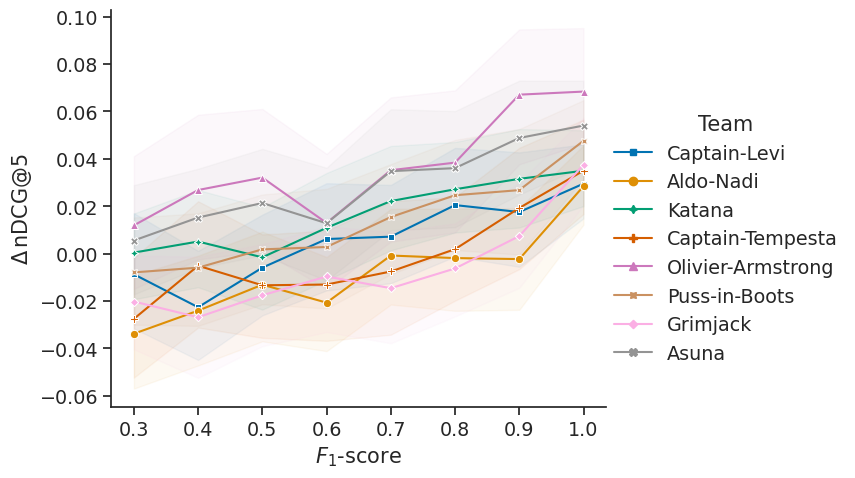

In [281]:
plot = relplot(
    data=df.dropna(subset=["target_f1"]),
    kind="line",
    x="target_f1",
    y="ΔnDCG@5 rel.",
    hue="team",
    hue_order=teams,
    palette=color_palette("colorblind")[:len(df["team"].unique())],
    markers=True,
    dashes=False,
    style="team",
    err_style="band",
    err_kws=dict(
        alpha=0.05,
    ),
    aspect=4 / 3,
)
plot._legend.set_title("Team")
plot.set_xlabels(r"$F_1$-score")
plot.set_ylabels(r"$\Delta\,$nDCG@5")
plot.savefig("data/plot-reranking-f1-best-run-diff-effectiveness-rel.pdf", transparent=True)
plot.savefig("data/plot-reranking-f1-best-run-diff-effectiveness-rel.png")
plot

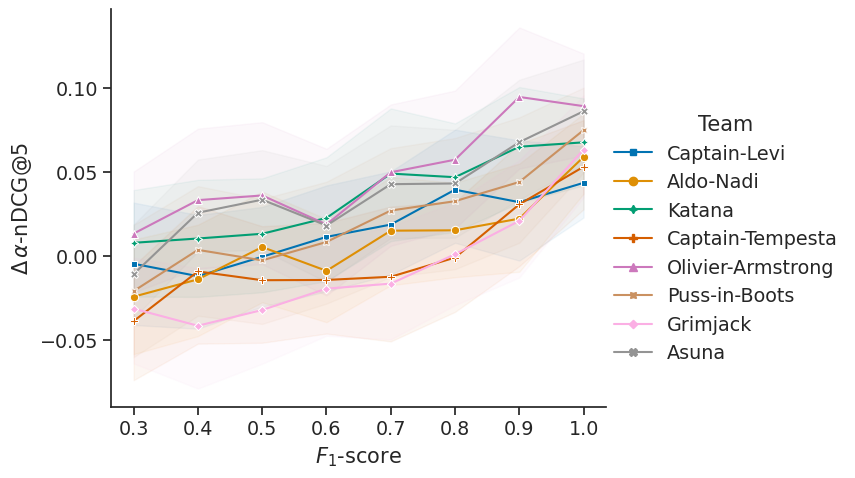

In [282]:
plot = relplot(
    data=df.dropna(subset=["target_f1"]),
    kind="line",
    x="target_f1",
    y="Δα-nDCG@5 rel.",
    hue="team",
    hue_order=teams,
    palette=color_palette("colorblind")[:len(df["team"].unique())],
    markers=True,
    dashes=False,
    style="team",
    err_style="band",
    err_kws=dict(
        alpha=0.05,
    ),
    aspect=4 / 3,
)
plot._legend.set_title("Team")
plot.set_xlabels(r"$F_1$-score")
plot.set_ylabels(r"$\Delta\,\alpha$-nDCG@5")
plot.savefig("data/plot-reranking-f1-best-run-diff-diversity-rel.pdf", transparent=True)
plot.savefig("data/plot-reranking-f1-best-run-diff-diversity-rel.png")
plot

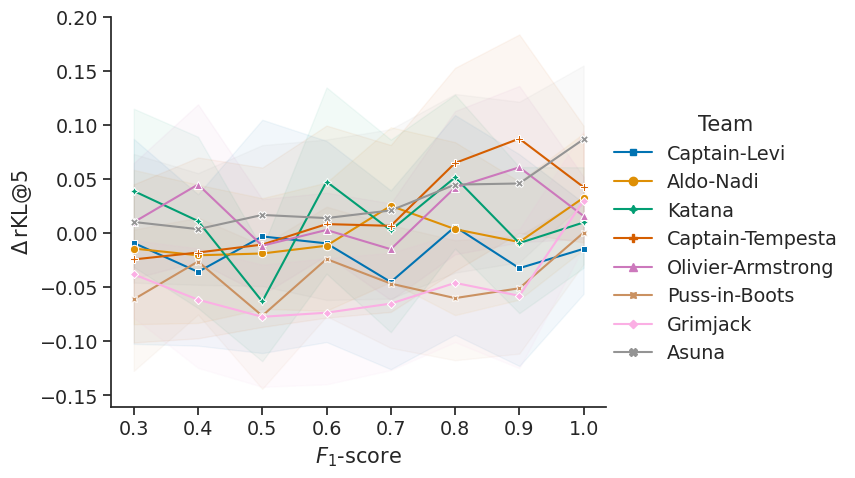

In [283]:
plot = relplot(
    data=df.dropna(subset=["target_f1"]),
    kind="line",
    x="target_f1",
    # y="ΔrND@5",
    y="ΔrKL@5",
    # y="ΔrRD@5",
    hue="team",
    hue_order=teams,
    palette=color_palette("colorblind")[:len(df["team"].unique())],
    markers=True,
    dashes=False,
    style="team",
    err_style="band",
    err_kws=dict(
        alpha=0.05,
    ),
    aspect=4 / 3,
)
plot._legend.set_title("Team")
plot.set_xlabels(r"$F_1$-score")
plot.set_ylabels(r"$\Delta\,$rKL@5")
plot.savefig("data/plot-reranking-f1-best-run-diff-fairness.pdf", transparent=True)
plot.savefig("data/plot-reranking-f1-best-run-diff-fairness.png")
plot

In [284]:
def improvements(df: DataFrame)-> DataFrame:
    baseline = df[df["name_index"] == 1].iloc[0]
    for measure_column in set(df.columns) - {"team", "run", "name", "name_index", "target_f1"}:
        if measure_column.endswith(" test"):
            continue
        df[f"{measure_column} test"].fillna("", inplace=True)
        sig = df[f"{measure_column} test"].str.contains("1")
        df[f"{measure_column} +"] = (((df[measure_column] - baseline[measure_column]) > 0) & sig).astype(int)
        df[f"{measure_column} -"] = (((df[measure_column] - baseline[measure_column]) < 0) & sig).astype(int)
    return df

In [285]:
df_all: DataFrame = read_csv("data/metrics-reranking-all-f1.csv")
df_all["run"] = df_all["name"].apply(lambda name: name.split(" + ")[0])
df_all["team"] = df_all["run"].apply(team_name)
df_all["target_f1"] = df_all["name"].apply(target_f1)
df_all = df_all.groupby(["run"], sort=False, group_keys=True).apply(improvements).reset_index(drop=True)
df_all

,name,name_index,nDCG@5 rel.,nDCG@5 rel. test,nDCG@5 qual.,nDCG@5 qual. test,F1,F1 test,"rKL@5(FIRST,SECOND,NEUTRAL)","rKL@5(FIRST,SECOND,NEUTRAL) test",...,"rRD@5(FIRST,SECOND,NEUTRAL) +","rRD@5(FIRST,SECOND,NEUTRAL) -",alpha_nDCG@5 rel. +,alpha_nDCG@5 rel. -,"rKL@5(FIRST,SECOND,NEUTRAL) +","rKL@5(FIRST,SECOND,NEUTRAL) -","rND@5(FIRST,SECOND,NEUTRAL) +","rND@5(FIRST,SECOND,NEUTRAL) -",alpha_nDCG@5 qual. +,alpha_nDCG@5 qual. -
0,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,1,0.547,2,0.570,2,0.156,"2,3,4,5,6",0.771,,...,0,0,0,0,0,0,0,0,0,0
1,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,2,0.575,1,0.599,1,1.000,"1,3,4,5,6",0.805,,...,0,0,1,0,0,0,0,0,1,0
2,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,3,0.564,,0.595,,0.947,"1,2,4,5,6",0.779,,...,0,0,0,0,0,0,0,0,0,0
3,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,4,0.561,,0.597,,0.901,"1,2,3,5,6",0.764,,...,0,0,0,0,0,0,0,0,0,0
4,Aldo-Nadi seupd2122-kueri_kueristopv2_BM2_fals...,5,0.559,,0.587,,0.850,"1,2,3,4,6",0.778,,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,Puss-in-Boots BM25-Baseline + ground-truth + s...,2,0.516,1,0.504,1,1.000,"1,3,4,5,6",0.866,,...,0,0,1,0,0,0,0,0,1,0
152,Puss-in-Boots BM25-Baseline + ground-truth(F1<...,3,0.518,"1,5",0.509,"5,6",0.947,"1,2,4,5,6",0.861,,...,0,0,1,0,0,0,0,0,1,0
153,Puss-in-Boots BM25-Baseline + ground-truth(F1<...,4,0.495,,0.492,,0.896,"1,2,3,5,6",0.815,,...,0,0,0,0,0,0,0,0,0,0
154,Puss-in-Boots BM25-Baseline + ground-truth(F1<...,5,0.484,3,0.480,3,0.832,"1,2,3,4,6",0.842,,...,0,0,0,0,0,0,0,0,0,0


In [286]:
first_bin = 0.80
last_bin = 1.00
bin_step = 0.05
bins = list(arange(
    first_bin - (bin_step / 2),
    last_bin + (bin_step / 2) + bin_step,
    bin_step,
))
bins

[0.775,
 0.8250000000000001,
 0.8750000000000001,
 0.9250000000000002,
 0.9750000000000002,
 1.0250000000000004]

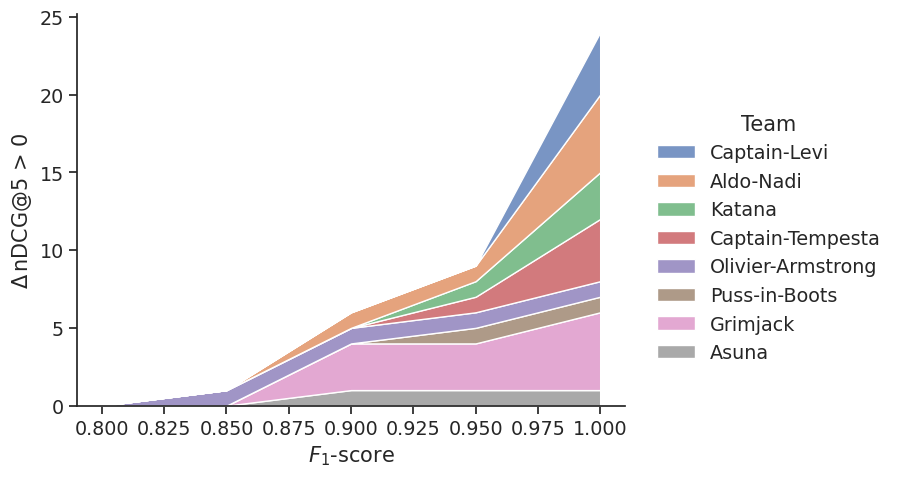

In [287]:
plot = displot(
    data=df_all.dropna(subset=["target_f1"]),
    kind="hist",
    element="poly",
    x="target_f1",
    weights="nDCG@5 rel. +",
    hue="team",
    hue_order=teams,
    bins=bins,
    aspect=4 / 3,
    multiple="stack",
)
plot._legend.set_title("Team")
plot.set_xlabels(r"$F_1$-score")
plot.set_ylabels(r"$\Delta\,$nDCG@5 > 0")
plot.savefig("data/plot-reranking-f1-num-significant-runs-effectiveness-rel.pdf", transparent=True)
plot.savefig("data/plot-reranking-f1-num-significant-runs-effectiveness-rel.png")
plot

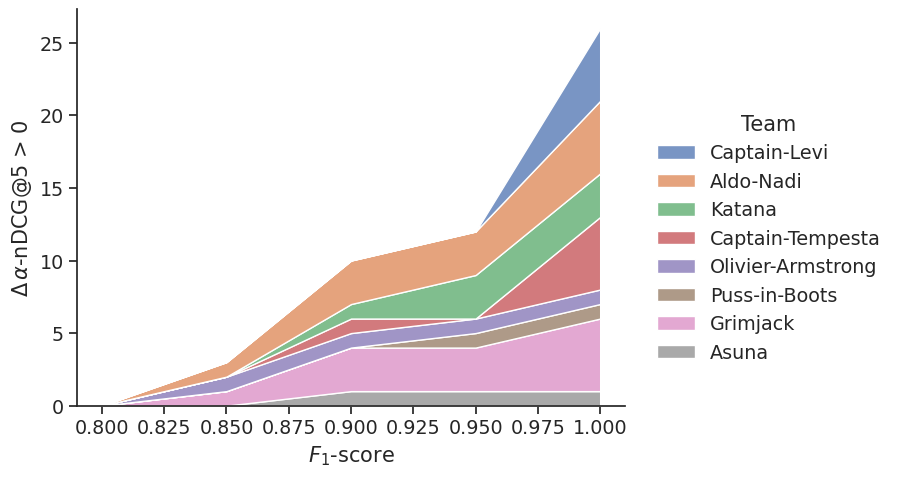

In [288]:
plot = displot(
    data=df_all.dropna(subset=["target_f1"]),
    kind="hist",
    element="poly",
    x="target_f1",
    weights="alpha_nDCG@5 rel. +",
    hue="team",
    hue_order=teams,
    bins=bins,
    aspect=4 / 3,
    multiple="stack",
)
plot._legend.set_title("Team")
plot.set_xlabels(r"$F_1$-score")
plot.set_ylabels(r"$\Delta\,\alpha$-nDCG@5 > 0")
plot.savefig("data/plot-reranking-f1-num-significant-runs-diversity-rel.pdf", transparent=True)
plot.savefig("data/plot-reranking-f1-num-significant-runs-diversity-rel.png")
plot

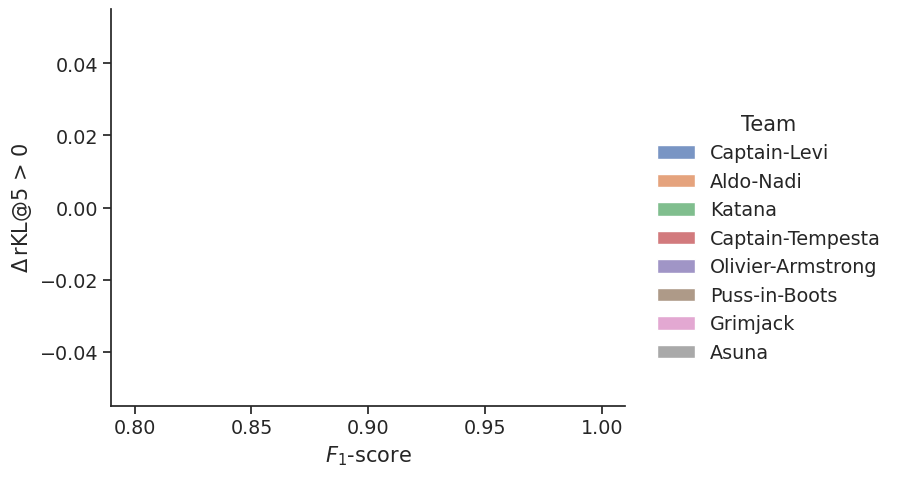

In [289]:
plot = displot(
    data=df_all.dropna(subset=["target_f1"]),
    kind="hist",
    element="poly",
    x="target_f1",
    weights="rKL@5(FIRST,SECOND,NEUTRAL) -",
    hue="team",
    hue_order=teams,
    bins=bins,
    aspect=4 / 3,
    multiple="stack",
)
plot._legend.set_title("Team")
plot.set_xlabels(r"$F_1$-score")
plot.set_ylabels(r"$\Delta\,$rKL@5 > 0")
plot.savefig("data/plot-reranking-f1-num-significant-runs-fairness.pdf", transparent=True)
plot.savefig("data/plot-reranking-f1-num-significant-runs-fairness.png")
plot